In [22]:
#import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
import csv
import cv2
from os import path
from os import listdir
from os.path import isfile, join , isdir
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

%matplotlib inline

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [2]:
# open all csv files

file_path = "."

csv_lines = []

csvfiles = [f for f in listdir(file_path+ "\\Data\\") if isfile(join(file_path + "\\Data\\",f))]
for c in csvfiles:
        
    with open(file_path + "\\Data\\"+c) as f:
        content = csv.reader(f)
        for line in content:
            csv_lines.append(line)

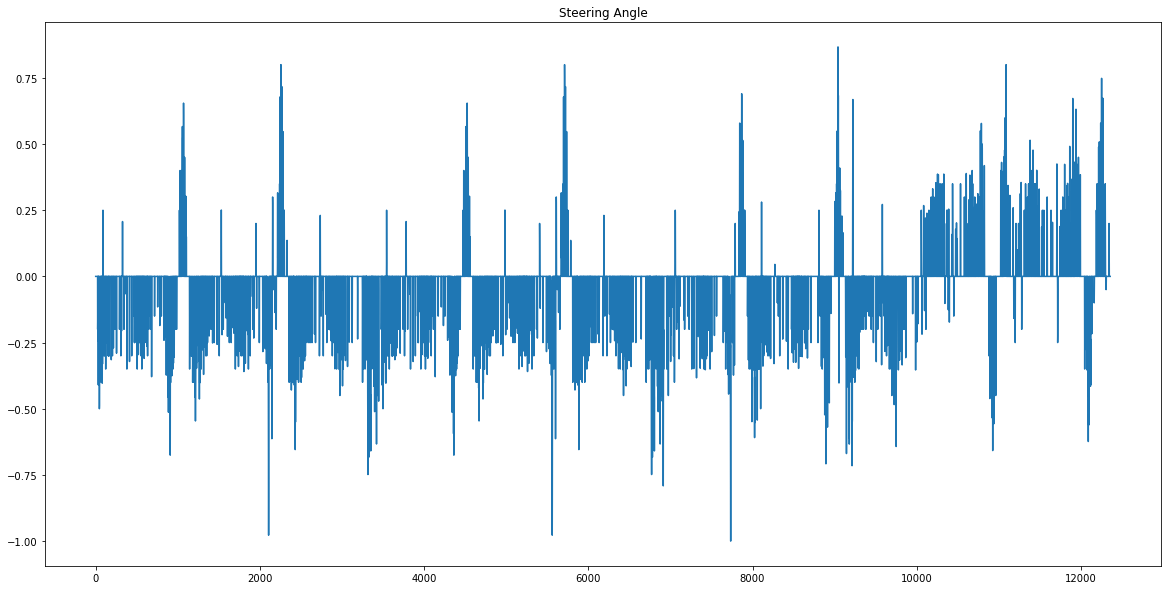

In [3]:
csv_lines = np.array(csv_lines)

plt.figure(figsize = (20,10))

plt.plot(csv_lines[:,3])
plt.title('Steering Angle')

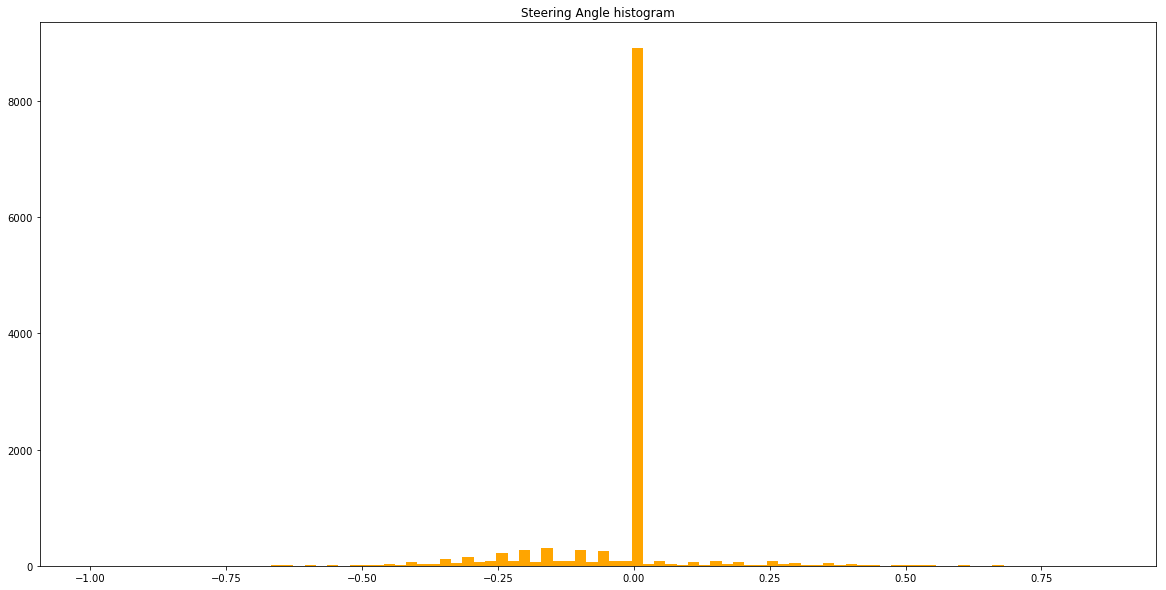

In [12]:
angles = csv_lines[:,3].astype(float)

plt.figure(figsize = (20,10))
plt.hist(angles, bins=90, color= 'orange', linewidth=0.1)
plt.title('Steering Angle histogram')

8878
12356
0.718517319521
3478
887


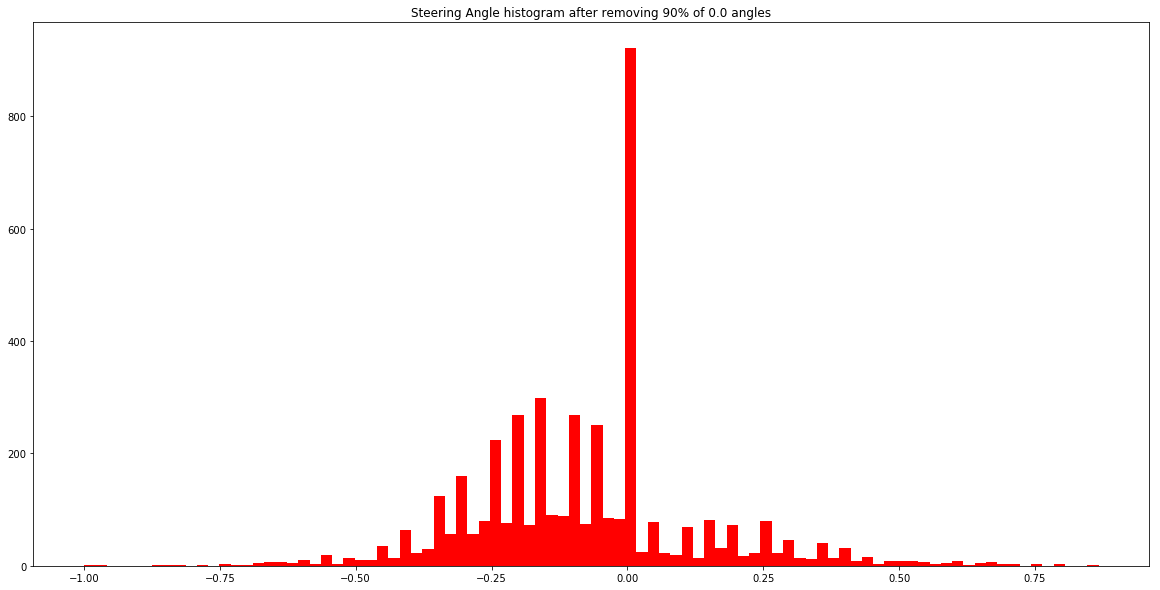

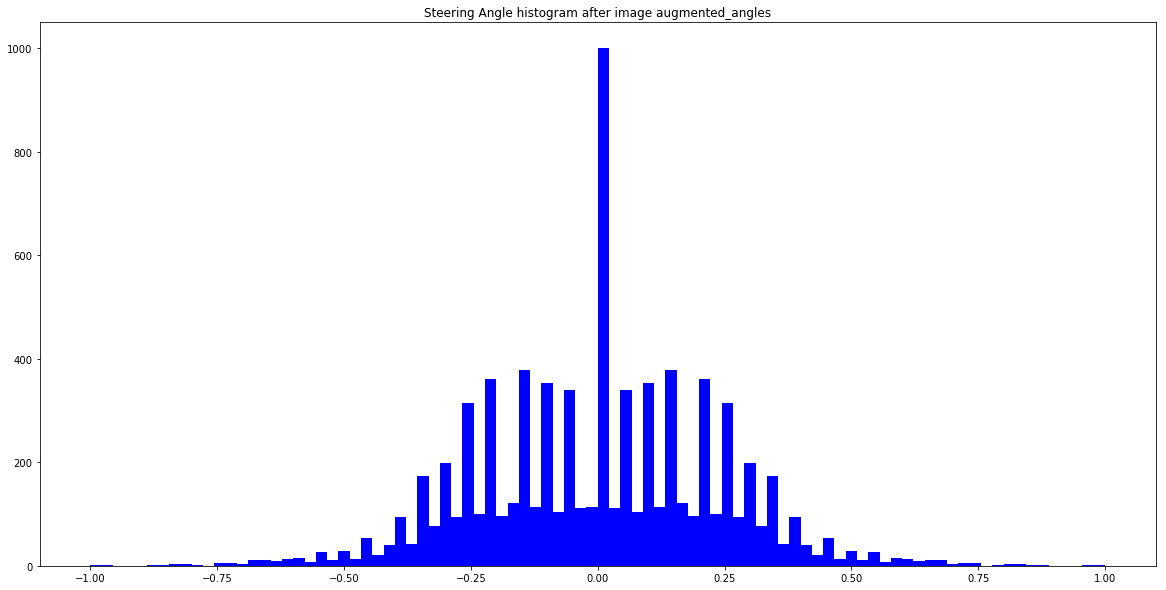

In [21]:
tol = 1e-16
zero_index = abs(angles) < tol

total_zeros = sum(zero_index)

print(total_zeros)
print(len(csv_lines))
print(total_zeros/len(csv_lines))

nonzero_angles_csv = csv_lines[~zero_index]
zero_angles_csv = csv_lines[zero_index]

keep_numbers = int((total_zeros*1) * .1)

keep_index = np.random.choice(len(zero_angles_csv), keep_numbers, replace=False)

zero_angles_csv = zero_angles_csv[keep_index]

print(len(nonzero_angles_csv))
print(len(zero_angles_csv))

new_csv = np.concatenate((nonzero_angles_csv, zero_angles_csv), axis=0)

new_csv = np.random.permutation(new_csv)


new_angles = new_csv[:,3].astype(float)

plt.figure(figsize = (20,10))
plt.hist(new_angles, bins=90, color= 'red', linewidth=0.1)
plt.title('Steering Angle histogram after removing 90% of 0.0 angles')

augmented_angles = []

for angle in new_angles:
    
    if abs(angle) >= tol:
        flipped_angle = -1.0 * angle
        augmented_angles.append(flipped_angle)
        

augmented_angles = np.array(augmented_angles)


new_angles = np.concatenate((augmented_angles, new_angles), axis=0)

plt.figure(figsize = (20,10))
plt.hist(new_angles, bins=90, color= 'blue', linewidth=0.1)
plt.title('Steering Angle histogram after image augmented_angles')

In [ ]:
def pre_processing(data, file_path, eps = 1e-16, keep = 0.2, visual_data = False):
    data = np.array(data)
    angles = data[:,3].astype(float)
    zero_index = abs(angles) < eps
    
    total_zeros = sum(zero_index)
    nonzero_angles_csv = data[~zero_index]
    zero_angles_csv = data[zero_index]
    
    keep_numbers = int((total_zeros*1)*keep)
    
    keep_index = np.random.choice(len(zero_angles_csv), keep_numbers, replace=False)
    
    zero_angles_csv = zero_angles_csv[keep_index]
    new_csv = np.concatenate((nonzero_angles_csv, zero_angles_csv), axis=0)
    new_csv = np.random.permutation(new_csv)
    
    if visual_data:
        new_angles = new_csv[:,3].astype(float)
        plt.figure(figsize = (20,10))
        plt.hist(new_angles, bins=90, color= 'red', linewidth=0.1)
        
    data = list(new_csv)
    
    center_images = list(map(lambda x: file_path+x[0][2:], (i for i in data)))
    left_images = list(map(lambda x: file_path+x[1][2:], (i for i in data)))
    right_images = list(map(lambda x: file_path+x[2][2:], (i for i in data)))
    angles = list(map(float, (i[3] for i in data)))


    for i in range(len(data)):
        data[i][0] = center_images[i]
        data[i][1] = left_images[i]
        data[i][2] = right_images[i]
        data[i][3] = angles[i]


    return data
    

data = pre_processing(csv_lines, file_path)


In [23]:
def data_augmentation(images, angles):
    augmented_images = []
    augmented_angles = []

    for image, angle in zip(images, angles):

        augmented_images.append(image)
        augmented_angles.append(angle)

        flipped_image = cv2.flip(image,1)
        flipped_angle = -1.0 * angle
        augmented_images.append(flipped_image)
        augmented_angles.append(flipped_angle)
    return augmented_images, augmented_angles


In [24]:
def generator(samples, batch_size=32, train_flag = True):
    num_samples = len(samples)
    correction = 0.2

    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                center_path = batch_sample[0]

                center_image = cv2.imread(center_path)

                center_angle = batch_sample[3]

                images.append(center_image)
                angles.append(center_angle)

                if train_flag:
                    left_path = batch_sample[1]
                    right_path = batch_sample[2]
                    left_image = cv2.imread(left_path)
                    right_image = cv2.imread(right_path)
                    images.append(left_image)
                    angles.append(center_angle + correction)
                    images.append(right_image)
                    angles.append(center_angle - correction)

            images, angles = data_augmentation(images, angles)

            X_train = np.array(images)
            y_train = np.array(angles)

            yield shuffle(X_train, y_train)

In [25]:
def cnn_model():

    model = Sequential()
    model.add(Lambda(lambda x: (x/127.5) - 1.0, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((70,25),(0,0))))

    model.add(Convolution2D(32,3,3,activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.1))
    model.add(Convolution2D(64,3,3,activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.1))
    model.add(Convolution2D(128,3,3, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(256,3,3, activation='relu'))
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dense(120))
    model.add(Dense(20))
    model.add(Dense(1))

    return model

In [29]:
file_path = "."
num_epoch = 10

csv_lines = []

csvfiles = [f for f in listdir(file_path+ "\\Data\\") if isfile(join(file_path + "\\Data\\",f))]
for c in csvfiles:
    print(c)
    with open(file_path + "\\Data\\"+c) as f:
        content = csv.reader(f)
        for line in content:
            csv_lines.append(line)
            


data = pre_processing(csv_lines, file_path)
train_data, valid_data = train_test_split(data, test_size=0.2)
train_generator = generator(train_data, batch_size=32)
validation_generator = generator(valid_data, batch_size=32, train_flag=False)

model = cnn_model()

    #model.summary()

model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator, samples_per_epoch= len(train_data)*6 , validation_data=validation_generator, nb_val_samples=len(valid_data), nb_epoch= num_epoch)

model.save('model.h5')

driving_log.csv
driving_log_1.csv
driving_log_2.csv
[ True  True  True ...,  True  True  True]


C:\Python27\envs\tensorflow\lib\site-packages\keras\layers\core.py:629: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 160, 320, 3)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
C:\Python27\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  import sys
C:\Python27\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
C:\Python27\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  del sys.path[0]
C:\P

Epoch 1/10


Exception in thread Thread-12:
Traceback (most recent call last):
  File "C:\Python27\envs\tensorflow\lib\threading.py", line 914, in _bootstrap_inner
    self.run()
  File "C:\Python27\envs\tensorflow\lib\threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Python27\envs\tensorflow\lib\site-packages\keras\utils\data_utils.py", line 560, in data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-24-daf1da3afe52>", line 28, in generator
    angles.append(center_angle + correction)
TypeError: Can't convert 'float' object to str implicitly



StopIteration: 